In [1]:
import scipy.io as sio

gt_path = 'data/jasper/jasper_ridge_gt.mat'
tmp = sio.loadmat(gt_path)

In [3]:
gt = tmp['data']

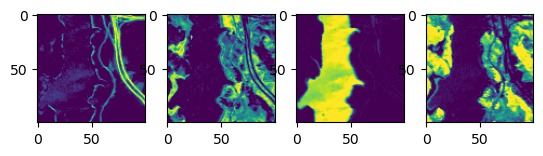

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 4)
for i in range(4):
    axs[i].imshow(gt[:, :, i])
plt.show()

In [2]:
# so in the dataset the arrangement of classes are road, soil, water, tree

(100, 100, 4)

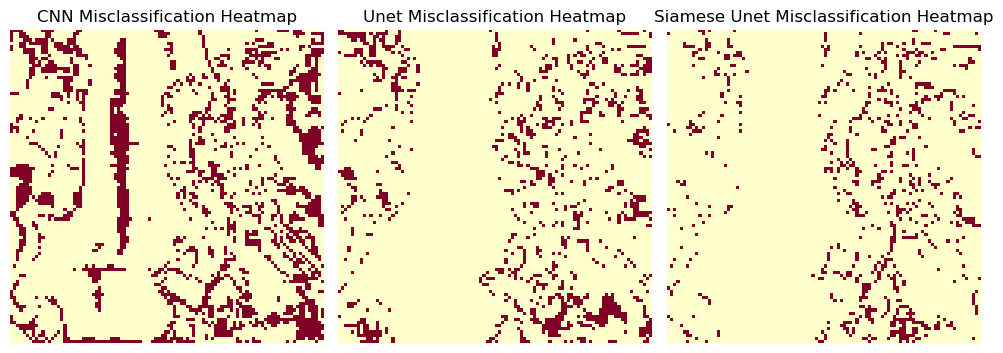

In [4]:
# plot misclassification heatmaps
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define the color mapping for each class
color_mapping = {
    0: [128, 64, 128],  # Road - Purple
    1: [244, 164, 96],  # Soil - SandyBrown
    2: [0, 0, 255],     # Water - Blue
    3: [34, 139, 34],   # Tree - ForestGreen
}

# Function to convert an image to a label map
def image_to_label_map(image, color_mapping):
    h, w, _ = image.shape
    label_map = np.zeros((h, w), dtype=np.int32)
    for label, color in color_mapping.items():
        mask = np.all(image == color, axis=-1)
        label_map[mask] = label
    return label_map

# Function to create a misclassification heatmap
def create_heatmap(gt_labels, pred_labels):
    misclassification = (gt_labels != pred_labels).astype(np.float32)
    return misclassification

# Load ground truth and model prediction images
gt_image = np.array(Image.open('../images/gt.png'))
model1_image = np.array(Image.open('../images/cnn.png'))
model2_image = np.array(Image.open('../images/unet.png'))
model3_image = np.array(Image.open('../images/ca_siamese.png'))

# Convert images to label maps
gt_labels = image_to_label_map(gt_image, color_mapping)
model1_labels = image_to_label_map(model1_image, color_mapping)
model2_labels = image_to_label_map(model2_image, color_mapping)
model3_labels = image_to_label_map(model3_image, color_mapping)

# Create misclassification heatmaps
heatmap1 = create_heatmap(gt_labels, model1_labels)
heatmap2 = create_heatmap(gt_labels, model2_labels)
heatmap3 = create_heatmap(gt_labels, model3_labels)

# Plot the heatmaps
fig, axes = plt.subplots(1, 3, figsize=(10, 10))
axes[0].imshow(heatmap1, cmap='YlOrRd', interpolation='nearest')
axes[0].set_title('CNN Misclassification Heatmap')
axes[1].imshow(heatmap2, cmap='YlOrRd', interpolation='nearest')
axes[1].set_title('Unet Misclassification Heatmap')
axes[2].imshow(heatmap3, cmap='YlOrRd', interpolation='nearest')
axes[2].set_title('Siamese Unet Misclassification Heatmap')

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()
